In [1]:
%pylab inline
import sklearn.model_selection
import scipy
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import os
import random
import pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
def load_data(dataset):
    d = np.load(dataset)
    mask = ~(np.isclose(d['permeabilities_x'], 0) | np.isclose(d['permeabilities_y'], 0)) & ((d['permeabilities_y'] + d['permeabilities_x']) / 2 < 25)
    images = d['images'][mask]
    porosities = d['porosities'][mask]
    permeabilities = (d['permeabilities_x'][mask] + d['permeabilities_y'][mask]) / 2
    images = np.reshape(images,(*(images.shape), 1))
    d.close()
    return images, porosities.astype(np.float32), permeabilities.astype(np.float32)

def load_data_half_inpermeable(dataset):
    d = np.load(dataset)
    mask = (np.isclose(d['permeabilities_x'], 0) | np.isclose(d['permeabilities_y'], 0)) & ((d['permeabilities_y'] + d['permeabilities_x']) / 2 < 25)
    images = d['images'][mask]
    porosities = d['porosities'][mask]
    permeabilities = (d['permeabilities_x'][mask] + d['permeabilities_y'][mask]) / 2
    images = np.reshape(images,(*(images.shape), 1))
    d.close()
    return images, porosities.astype(np.float32), permeabilities.astype(np.float32)

def load_data90(dataset):
    d = np.load(dataset)
    mask = (np.isclose(d['permeabilities_x'], 0) | np.isclose(d['permeabilities_y'], 0)) & ((d['permeabilities_y'] + d['permeabilities_x']) / 2 < 25)
    images = d['images'][mask]
    porosities = d['porosities'][mask]
    permeabilities = (d['permeabilities_x'][mask] + d['permeabilities_y'][mask]) / 2
    images = np.rot90(images,axes=(2,1))
    images = np.reshape(images,(*(images.shape), 1))
    d.close()
    return images, porosities.astype(np.float32), permeabilities.astype(np.float32)

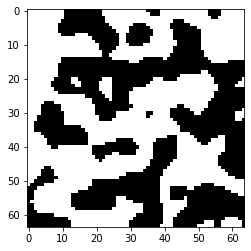

In [3]:
images,_,permeabilities = load_data('datasetsXY/gaussian_sig1.5-2.5_f0.1-0.5_n100000.npz')
plt.imshow(images[4], cmap='gray')
plt.savefig('images/ex_first_layer.png')

In [3]:
all_datasets = os.listdir('datasetsXY')
random.shuffle(all_datasets)
datasets = all_datasets
print(datasets)
history = []
images = []
permeabilities = []
for dataset in datasets:
    images_n, _, permeabilities_n = load_data('datasetsXY/' + dataset)
    images.extend(images_n)
    permeabilities.extend(permeabilities_n)
    del(images_n)
    del(permeabilities_n)

    """
    images_n, _, permeabilities_n = load_data90('datasetsXY/' + dataset)
    images.extend(images_n)
    permeabilities.extend(permeabilities_n)
    del(images_n)
    del(permeabilities_n)
    images_n, porosities_n, permeabilities_n = load_dataTranspose('datasetsXY/' + dataset)
    images.append(images_n)
    porosities.append(porosities_n)
    permeabilities.append(permeabilities_n)
    """

permeabilities = np.array(permeabilities)
images = np.array(images)

['normal_rad3pm0.5_num120-160_n100000.npz', 'gaussian_sig1.5-2.5_f0.1-0.5_n100000.npz', 'normal_rad4pm2_num30-120_2_n100000.npz', 'normal_rad3pm0.5_num120-160_2_n100000.npz', 'normal_rad5pm0.5_num30-60_n100000.npz', 'normal_rad5pm0.5_num30-60_2_n100000.npz', 'gaussian_sig1.5-3_f0.1-0.6_n100000.npz', 'gaussian_sig1.5-2.5_f0.2-0.5_n100000.npz', 'normal_rad4pm2_num30-120_n100000.npz', 'gaussian_sig1.5-3_f0.1-0.5_n100000.npz']


In [20]:
name = 'leaky_relu_43000'
model = tf.keras.models.load_model(f'models/{name}/')
hist_file = open(f'models/{name}.history', 'rb')
history = pickle.load(hist_file)
hist_file.close()

In [5]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 64, 64, 16)        256       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 16)        4096      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 16)        4096      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 16, 16, 16)       

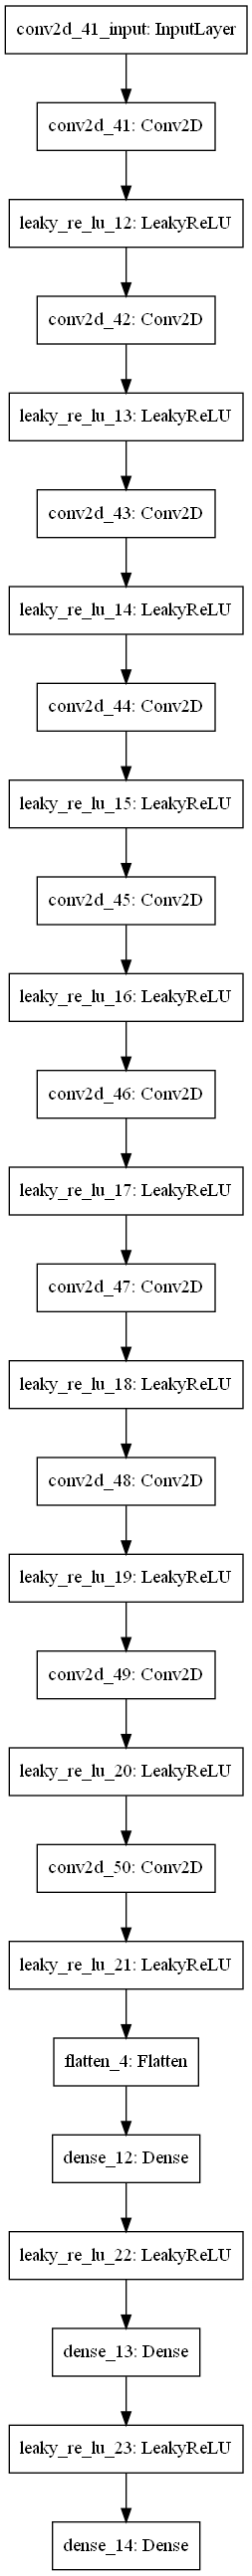

In [6]:
tf.keras.utils.plot_model(model)

5.716151237487793


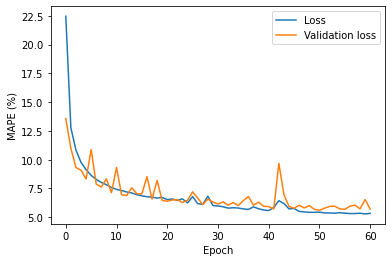

In [14]:
plt.plot(history['loss']);
plt.plot(history['val_loss']);
plt.legend(('Loss', 'Validation loss'))
plt.xlabel('Epoch')
plt.ylabel('MAPE (%)')
plt.savefig('images/leaky_relu_43000.png', dpi=600)
print(history['val_loss'][-1])

In [21]:
predictions = model.predict(images).flatten()

In [22]:
np.min(predictions)

-1.181248

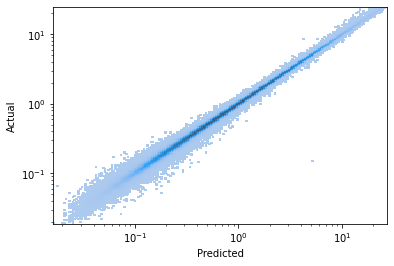

In [23]:
x = np.linspace(np.min((np.min(permeabilities), np.min(predictions))), np.max((np.max(permeabilities), np.max(predictions))))
#ax = sns.lineplot(x = x, y = x, color='r')
ax = sns.histplot(x = predictions[predictions>0], y = permeabilities[predictions>0], log_scale=(True,True))
ax.set_xlim([np.min(predictions[predictions>0]),np.max(predictions)])
ax.set_ylim([np.min(permeabilities[permeabilities>0]),np.max(permeabilities)])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.get_figure().savefig("images/mooi_plotje_leaky_relu_43000.png", dpi=600)

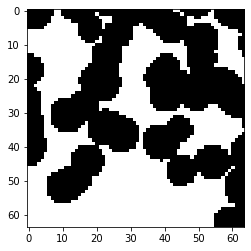

In [13]:
errors = np.abs((permeabilities - predictions) / permeabilities)*100
max_err_idx = np.argmax(errors)
plt.imshow(images[max_err_idx],cmap='gray')
plt.savefig('images/stom_spul.png')
np.save('bad.np', images[max_err_idx])

In [57]:
calculation_time = 0.08846139999877778 # From different script

start = time.perf_counter()
prediction = model.predict(images[:1000000]).flatten()[0]
end = time.perf_counter()

prediction_time = (end-start)/1000000

print(f"Prediction time: {prediction_time}s")

print(f"Speedup: {calculation_time/prediction_time}x")

Prediction time: 3.195159230000013e-05s
Speedup: 2768.6069341457332x


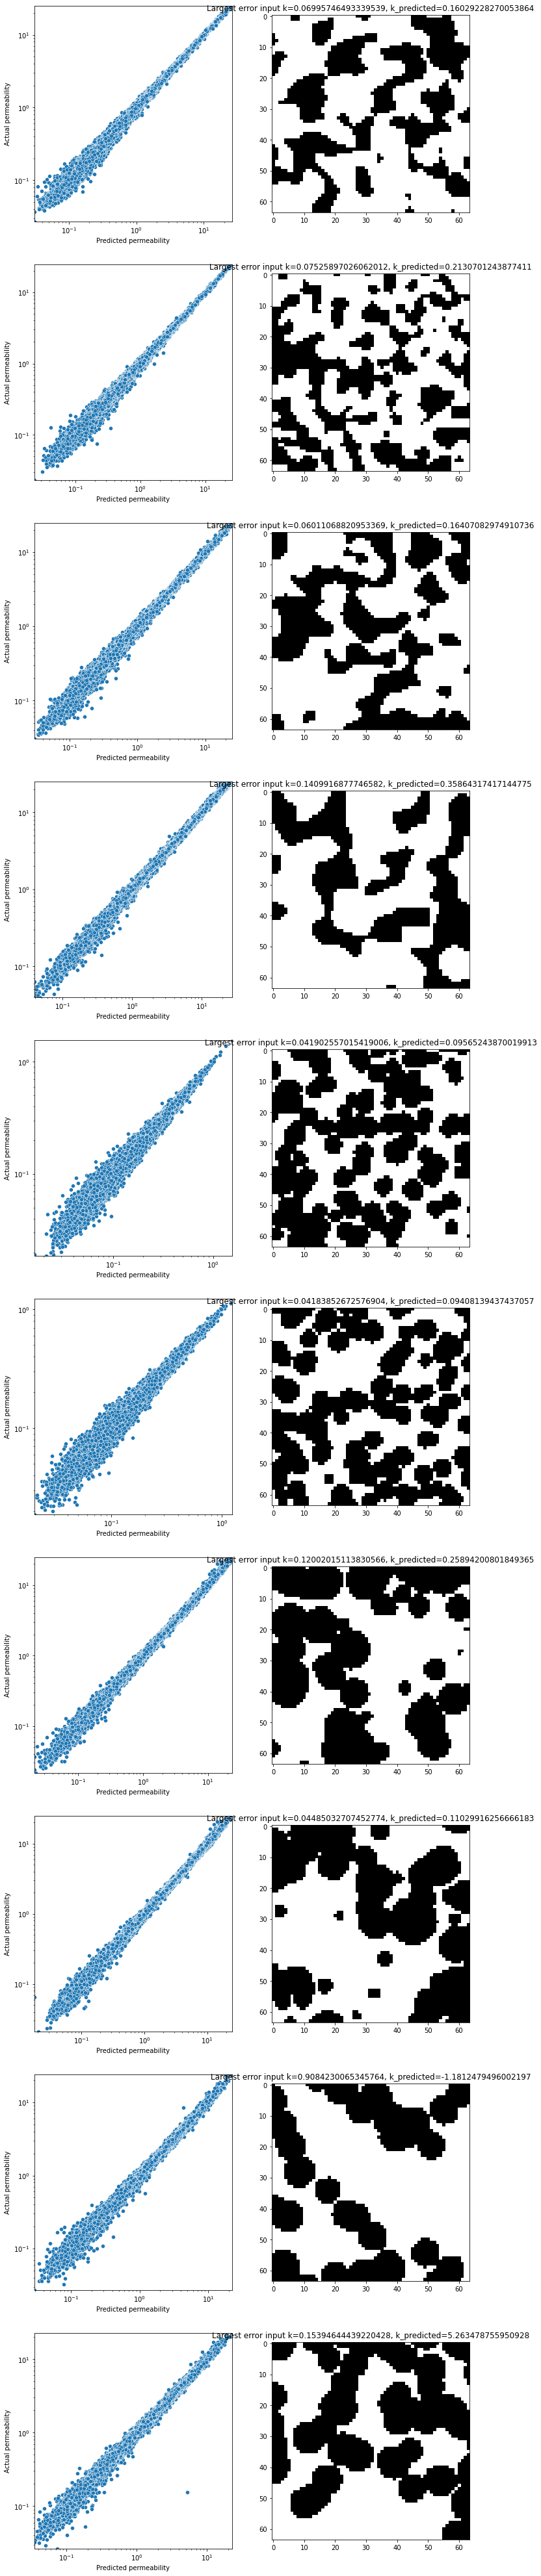

In [64]:
datasets = os.listdir('datasetsXY')

fig, axes = plt.subplots(len(datasets), 2, figsize=(12,6*12))

for i in range(len(datasets)):
    images, porosities, permeabilities = load_data('datasetsXY/' + datasets[i])
    predicted = model.predict(images).flatten()
    
    errors = np.abs((permeabilities - predicted) / permeabilities)*100
    max_err_idx = np.argmax(errors)
    
    sns.scatterplot(ax = axes[i, 0], x = predicted, y = permeabilities)
    axes[i,1].imshow(images[max_err_idx], cmap='gray')
    axes[i,1].set_title(f'Largest error input k={permeabilities[max_err_idx]}, k_predicted={predicted[max_err_idx]}')

    axes[i,0].set_xscale('log')
    axes[i,0].set_yscale('log')
    axes[i,0].set_xlim([np.min(predicted[predicted>0]),np.max(predicted)])
    axes[i,0].set_ylim([np.min(permeabilities[permeabilities>0]),np.max(permeabilities)])
    axes[i,0].set_xlabel('Predicted permeability');
    axes[i,0].set_ylabel('Actual permeability');
    #axes[i,0].set_title(f'Dataset: {datasets[i]}, mape: {np.mean(errors)}')

Mape: 36.46239866467751


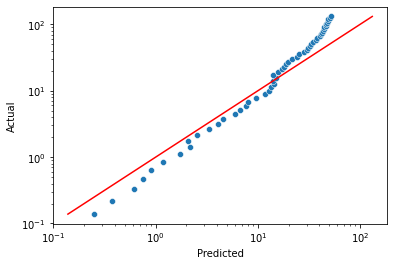

In [52]:
def predict_flow_channel(h):
    start = int((64-h)/2)

    i = np.zeros((64,64))
    i[start:start+h, :] = 1
    i = i.reshape((64,64,1))
    iarr = np.array([i])
    prediction = model.predict(iarr).flatten()[0]
    #plt.imshow(i, cmap='gray')
    #plt.savefig('images/flow_channel.png')
    return prediction

def calculate_flow_channel(h):
    k_x = h**3/12/65
    return k_x/2

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


#error = abs(prediction-actual)/actual*100

predicted = []
actual = []

for h in range (6,60):
    predicted.append(predict_flow_channel(h))
    actual.append(calculate_flow_channel(h))

#plt.imshow(i)
print(f'Mape: {mean_absolute_percentage_error(actual, predicted)}')
#print(f'Prediction: {prediction}, Actual: {actual}, error: {abs(prediction-actual)/actual*100}%')

x = np.linspace(np.min((np.min(actual), np.min(predicted))), np.max((np.max(actual), np.max(predicted))))
ax = sns.lineplot(x = x, y = x, color='r')
sns.scatterplot(x = predicted, y = actual, ax=ax)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.get_figure().savefig("images/flow_channel_test.png")

Calculation time: 6.924843750000242e-05s
Prediction: 9.330384254455566, Actual: 10.256410256410257, precision: 9.028753519058236%


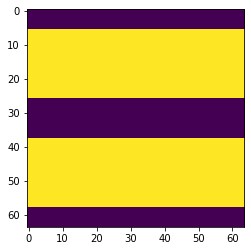

In [38]:
h = 20
start1 = int((64/2-h)/2)
start2 = int((64/2-h)/2)+32

i = np.zeros((64,64))
i[start1:start1+h, :] = 1
i[start2:start2+h, :] = 1
i = i.reshape((64,64,1))
n = 1024
iarr = np.array([i]*n)

start = time.perf_counter()
prediction = model.predict(iarr).flatten()[0]
end = time.perf_counter()

print(f"Calculation time: {(end-start)/n}s")

def calculate_flow_channel(h):
    # Using navier stokes:
    P_right = 0.5
    P_left = 1
    
    deltaP = (P_right-P_left)/(65)
    y = np.arange(0, 12)
    flux = -deltaP*h**3/12
    k_x = -flux/(P_right-P_left)
    k_y = 0
    return k_x, k_y

actual = np.mean(calculate_flow_channel(h))*2

plt.imshow(i)

print(f'Prediction: {prediction}, Actual: {actual}, error: {abs(prediction-actual)/actual*100}%')

Prediction: 4.044188499450684, predicted90: 3.642857789993286, Actual: 5.3128205128205135, absolute percentage error: 23.87869137134332%


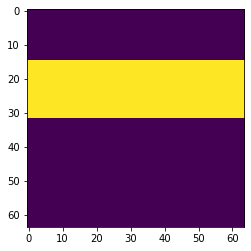

In [57]:
def test_channels(n_channels):
    img = np.zeros((64,64))
    actual = 0
    for i in range(n_channels):
        h = np.random.randint(10,20)
        start = np.random.randint(1,63-h)
        img[start:start+h, :] = 1
        actual += np.mean(calculate_flow_channel(h))
    
    img = img.reshape((64,64,1))
    iarr = np.array([img])
    predicted = model.predict(iarr).flatten()[0]
    img90 = np.rot90(img).reshape((64,64,1))
    iarr90 = np.array([img90])
    predicted90 = model.predict(iarr90).flatten()[0]
    return img, actual, predicted, predicted90

img, actual, predicted, predicted90 = test_channels(2)
print(f'Prediction: {predicted}, predicted90: {predicted90}, Actual: {actual}, absolute percentage error: {np.abs(actual-predicted)/actual*100}%')
plt.imshow(img);

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        4096      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        4096      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        4096      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 16)        4096      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 16)          4096      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 16)          4

In [77]:
def visualize_first_layer(layers, img):
    vis = []
    
    res = img.reshape((1,64,64,1))
    
    
    for layer in layers:
        print(layer)
        res = layer(res).numpy()
        outputs = res.shape[3]
        fig, axes = plt.subplots(int(outputs / 4), 4, figsize=(16, outputs))
        fig.suptitle(f'Layer: {layer.name}', fontsize=16)
        axes = axes.flatten()
        for i in range(outputs):
            axes[i].imshow(res[:,:,:,i].reshape(np.flip(res[:,:,:,i].shape)))

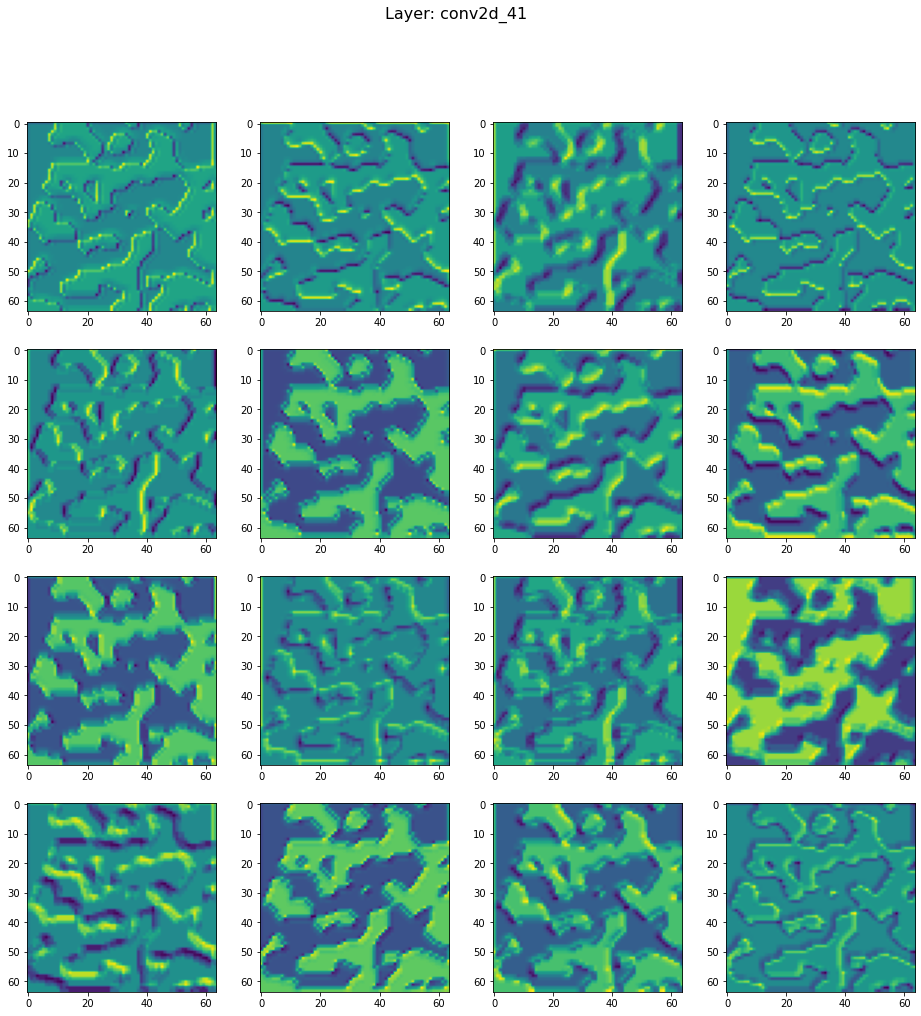

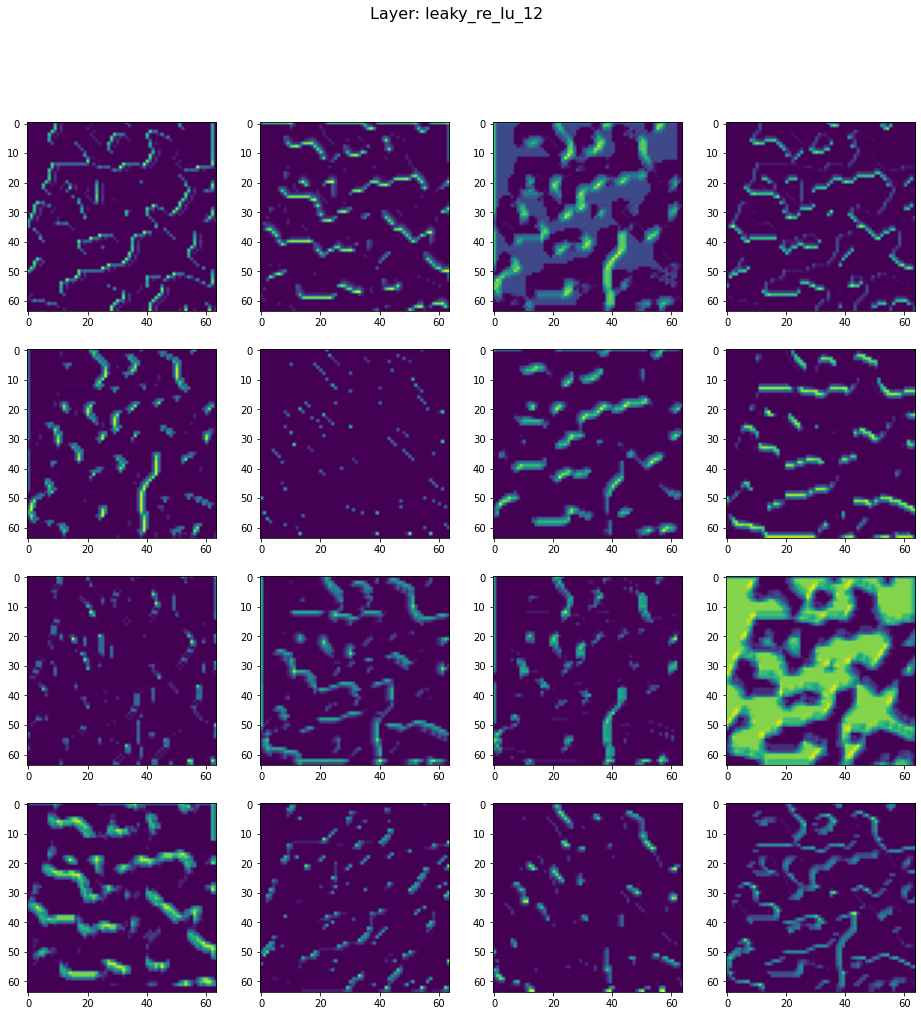

In [78]:
visualize_first_layer(model.layers[0:2], images[4].astype(np.float32))